In [1]:
#!conda create -n Jupyter_Dock python=3.8
#!conda activate Jupyter_Dock
#!conda install rdkit cython
#!conda install -c conda-forge py3dmol
#%pip install vina
#%pip install meeko
#%pip install git+https://github.com/chemosim-lab/ProLIF.git 


In [2]:
import MDAnalysis as mda
import os
import nglview as nv

In [3]:
os.makedirs("ligands", exist_ok=True)
os.makedirs("proteins", exist_ok=True)
os.makedirs("pdbqt", exist_ok=True)

In [4]:
u = mda.Universe("proteins/mmdb_9BQJ.pdb")
u

<Universe with 8524 atoms>

In [5]:
view = nv.show_mdanalysis(u)
view

NGLWidget()

In [6]:
protein = u.select_atoms("protein")
lig = u.select_atoms("record_type HETATM and not name H*")
water = u.select_atoms("resname HOH")
water

<AtomGroup with 1 atom>

In [7]:
view = nv.show_mdanalysis(protein)
view.clear_representations()
view.add_representation("surface", colorScheme="hydrophobicity")
lig_view = view.add_component(lig)
lig_view.add_representation("ball+stick")
water_view = view.add_component(water)
water_view.add_representation("spacefill")

view

NGLWidget()

In [8]:
os.makedirs("protein_to_dock", exist_ok=True)
protein.write("protein_to_dock/prot_9bqj.pdb")

/home/sergei4/anaconda3/envs/JupyterDock/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:753: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/sergei4/anaconda3/envs/JupyterDock/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [9]:
!pdb2pqr --pdb-output protein_to_dock/9bqj_h --pH=7.4 protein_to_dock/prot_9bqj.pdb protein_to_dock/prot_9bqj.pqr --whitespace

INFO:PDB2PQR v3.6.1: biomolecular structure conversion software.
INFO:Please cite:  Jurrus E, et al.  Improvements to the APBS biomolecular solvation software suite.  Protein Sci 27 112-128 (2018).
INFO:Please cite:  Dolinsky TJ, et al.  PDB2PQR: expanding and upgrading automated preparation of biomolecular structures for molecular simulations. Nucleic Acids Res 35 W522-W525 (2007).
INFO:Checking and transforming input arguments.
INFO:Loading topology files.
INFO:Loading molecule: protein_to_dock/prot_9bqj.pdb
ERROR:Error parsing line: invalid literal for int() with base 10: ''
ERROR:<REMARK     1 NCBI PDB FORMAT VERSION 6.2>
ERROR:Truncating remaining errors for record type:REMARK

ERROR:['REMARK']
INFO:Setting up molecule.
INFO:Created biomolecule object with 1122 residues and 8495 atoms.
INFO:Setting termini states for biomolecule chains.
INFO:Loading forcefield.
INFO:Loading hydrogen topology definitions.
INFO:Attempting to repair 316 missing atoms in biomolecule.
INFO:Added atom C

In [10]:
pocket_center = lig.center_of_geometry()
print(pocket_center)

[125.72579272 166.76213758 153.04737907]


In [11]:
ligand_box = lig.positions.max(axis=0) - lig.positions.min(axis=0) + 5
print(ligand_box)

[ 9.4109955 15.772995  19.093002 ]


In [12]:
pocket_center = pocket_center.tolist()
ligand_box = ligand_box.tolist()

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.ipython_useSVG = True  
IPythonConsole.drawOptions.addAtomIndices = True  
IPythonConsole.molSize = 600,600 

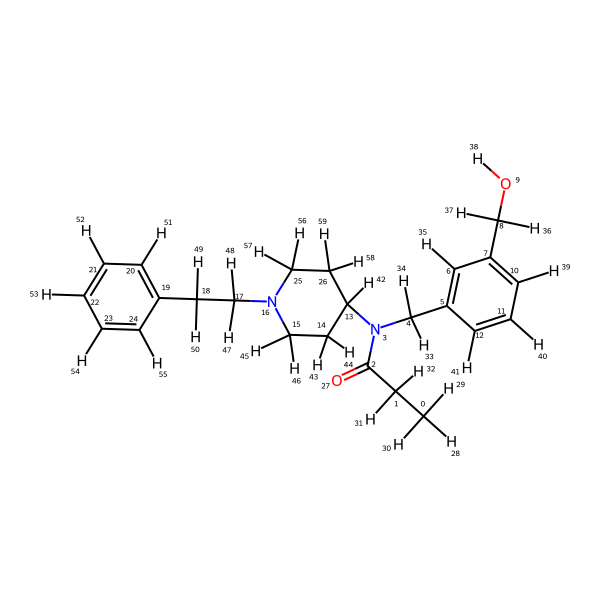

In [14]:
ligand = Chem.MolFromSmiles("CCC(N(Cc1cc(CO)ccc1)C1CCN(CCc2ccccc2)CC1)=O", sanitize=True)
ligand_H = Chem.AddHs(ligand)

ligand_H

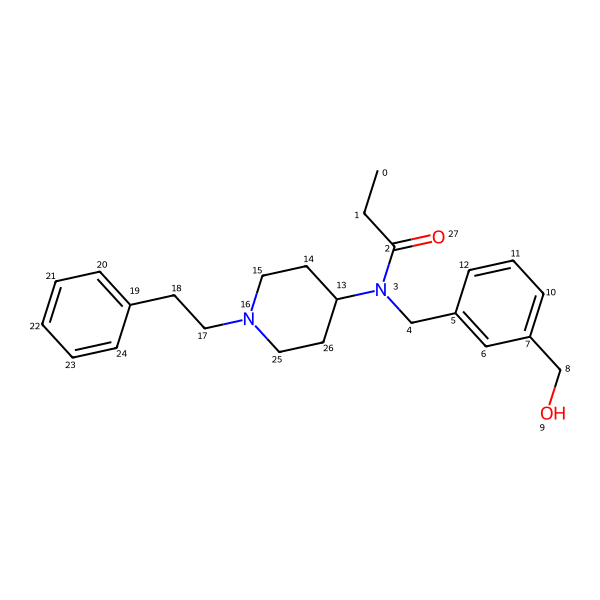

In [15]:
ligand

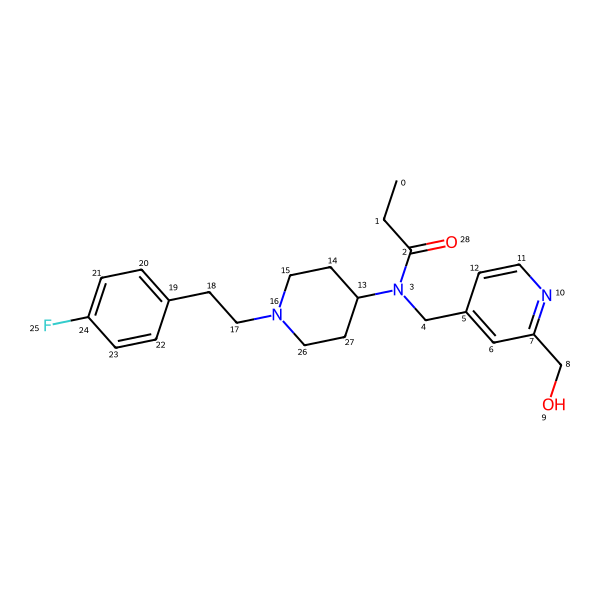

In [16]:
ligand_FN = Chem.MolFromSmiles("CCC(N(Cc1cc(CO)ncc1)C1CCN(CCc(cc2)ccc2F)CC1)=O", sanitize=True)
ligand_FNH = Chem.AddHs(ligand_FN)

ligand_FN

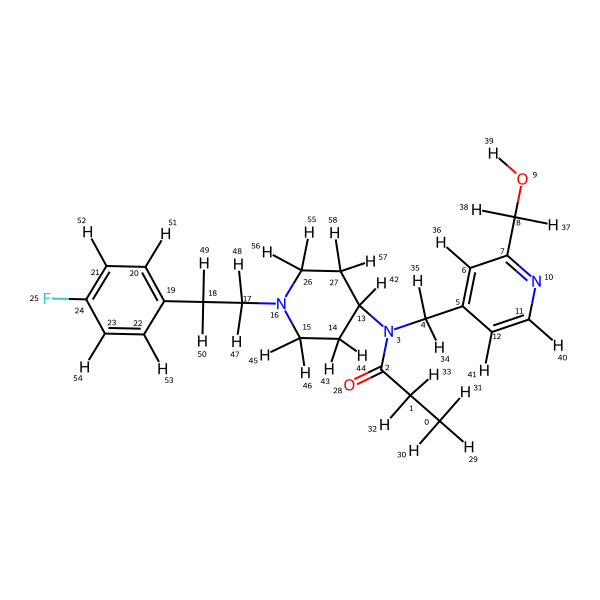

In [17]:
ligand_FNH

In [18]:
Chem.AllChem.EmbedMultipleConfs(ligand_H, numConfs=10)

In [19]:
Chem.AllChem.EmbedMultipleConfs(ligand_FNH, numConfs=10)

In [20]:

import os


os.makedirs("ligands_to_dock", exist_ok=True)



Chem.MolToMolFile(ligand_H, 'ligands_to_dock/lig.sdf')
Chem.MolToMolFile(ligand_FNH, 'ligands_to_dock/lig_FN.sdf')


In [21]:
! mk_prepare_ligand.py -i ligands_to_dock/lig.sdf -o pdbqt/lig.pdbqt
! mk_prepare_ligand.py -i ligands_to_dock/lig_FN.sdf -o pdbqt/lig_FN.pdbqt


In [22]:
u = mda.Universe("protein_to_dock/prot_9bqj.pqr")
u.atoms.write("pdbqt/9bqj.pdbqt")

/home/sergei4/anaconda3/envs/JupyterDock/lib/python3.8/site-packages/MDAnalysis/coordinates/PDBQT.py:290: UserWarning: Supplied AtomGroup was missing the following attributes: altLocs, occupancies, tempfactors. These will be written with default values. 
  warnings.warn(


In [23]:
with open(f"pdbqt/9bqj.pdbqt", 'r') as file:
    file_content = file.read()


file_content = file_content.replace('TITLE', 'REMARK').replace('CRYST1', 'REMARK')


with open(f"pdbqt/9bqj.pdbqt", 'w') as file:
    file.write(file_content)

In [24]:
from vina import Vina

v = Vina(sf_name="vina")

In [25]:
v.set_receptor(f"pdbqt/9bqj.pdbqt")
v.set_ligand_from_file(f"pdbqt/lig.pdbqt")
v.compute_vina_maps(center=pocket_center, box_size=ligand_box)

Computing Vina grid ... done.


In [26]:
v.dock(exhaustiveness=5, n_poses=10)

Performing docking (random seed: 1133478373) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -7.886          0          0
   2       -7.774      2.798      8.347
   3       -7.596      1.819      2.459
   4       -7.445      1.851      4.398
   5       -7.441      1.722      2.379
   6       -7.334      1.977      3.302
   7       -7.214      3.431      7.301
   8       -7.122      2.595      8.261
   9       -6.671      3.476      7.821
  10       -6.617      3.538      8.858


In [27]:
v.set_receptor(f"pdbqt/9bqj.pdbqt")
v.set_ligand_from_file(f"pdbqt/lig_FN.pdbqt")
v.compute_vina_maps(center=pocket_center, box_size=ligand_box)

Computing Vina grid ... done.


In [28]:
v.dock(exhaustiveness=8, n_poses=10)

Performing docking (random seed: 1133478373) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.462          0          0
   2       -8.282      4.047      8.973
   3        -8.25       1.39      2.131
   4       -8.206      4.204        9.9
   5       -8.172      1.577      1.935
   6       -8.033      4.119      9.199
   7       -7.952      4.151       9.43
   8       -7.811        3.9      9.294
   9       -7.708      4.106      9.125
  10       -7.678       4.27      9.559


In [29]:
#Remove water from protein
u = mda.Universe("proteins/9BQJ_H2O.pdb")
protein = u.select_atoms("protein")
protein.write("protein_to_dock/9BQJ_H2O.pdb")

In [30]:
!pdb2pqr --pdb-output protein_to_dock/9BQJ_H2O_H --pH=7.4 protein_to_dock/prot_9bqj.pdb protein_to_dock/9BQJ_H2O_H.pqr --whitespace

INFO:PDB2PQR v3.6.1: biomolecular structure conversion software.
INFO:Please cite:  Jurrus E, et al.  Improvements to the APBS biomolecular solvation software suite.  Protein Sci 27 112-128 (2018).
INFO:Please cite:  Dolinsky TJ, et al.  PDB2PQR: expanding and upgrading automated preparation of biomolecular structures for molecular simulations. Nucleic Acids Res 35 W522-W525 (2007).
INFO:Checking and transforming input arguments.
INFO:Loading topology files.
INFO:Loading molecule: protein_to_dock/prot_9bqj.pdb
ERROR:Error parsing line: invalid literal for int() with base 10: ''
ERROR:<REMARK     1 NCBI PDB FORMAT VERSION 6.2>
ERROR:Truncating remaining errors for record type:REMARK

ERROR:['REMARK']
INFO:Setting up molecule.
INFO:Created biomolecule object with 1122 residues and 8495 atoms.
INFO:Setting termini states for biomolecule chains.
INFO:Loading forcefield.
INFO:Loading hydrogen topology definitions.
INFO:Attempting to repair 316 missing atoms in biomolecule.
INFO:Added atom C

In [31]:
u = mda.Universe("protein_to_dock/9BQJ_H2O_H.pqr")
u.atoms.write("pdbqt/9BQJ_H2O_H.pdbqt")

In [32]:
with open(f"pdbqt/9BQJ_H2O_H.pdbqt", 'r') as file:
    file_content = file.read()


file_content = file_content.replace('TITLE', 'REMARK').replace('CRYST1', 'REMARK')


with open(f"pdbqt/9BQJ_H2O_H.pdbqt", 'w') as file:
    file.write(file_content)

In [33]:
v.set_receptor(f"pdbqt/9BQJ_H2O_H.pdbqt")
v.set_ligand_from_file(f"pdbqt/lig.pdbqt")
v.compute_vina_maps(center=pocket_center, box_size=ligand_box)

Computing Vina grid ... done.


In [34]:
v.dock(exhaustiveness=8, n_poses=10)

Performing docking (random seed: 1133478373) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -7.987          0          0
   2       -7.971      1.166      1.903
   3       -7.848      2.784      8.656
   4       -7.671       1.42      1.997
   5        -7.52      2.077      4.303
   6       -7.516      1.831      2.705
   7       -7.408      2.157      3.469
   8       -7.288      3.452        7.6
   9       -7.217      1.921      2.871
  10       -7.197      2.646      8.648


In [35]:
v.set_receptor(f"pdbqt/9BQJ_H2O_H.pdbqt")
v.set_ligand_from_file(f"pdbqt/lig_FN.pdbqt")
v.compute_vina_maps(center=pocket_center, box_size=ligand_box)

Computing Vina grid ... done.


In [36]:
v.dock(exhaustiveness=8, n_poses=10)

Performing docking (random seed: 1133478373) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -8.462          0          0
   2       -8.282      4.047      8.973
   3        -8.25       1.39      2.131
   4       -8.206      4.204        9.9
   5       -8.172      1.577      1.935
   6       -8.033      4.119      9.199
   7       -7.952      4.151       9.43
   8       -7.811        3.9      9.294
   9       -7.708      4.106      9.125
  10       -7.678       4.27      9.559
